# PREPROCESSING

### IMPORT




In [ ]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from keras.applications.resnet_v2 import preprocess_input



tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### READ IMAGES AND SET LABELS

In [ ]:
#UNZIP THE DATASET, ALREADY PREVIOUSLY SPLIT
!unzip "/content/data_splitted_final.zip" -d "/content"

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data_splitted_final/train/Species6/00146.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00146.jpg  
  inflating: /content/data_splitted_final/train/Species6/00152.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00152.jpg  
  inflating: /content/data_splitted_final/train/Species6/00185.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00185.jpg  
  inflating: /content/data_splitted_final/train/Species6/00191.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00191.jpg  
  inflating: /content/data_splitted_final/train/Species6/00032.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00032.jpg  
  inflating: /content/data_splitted_final/train/Species6/00027.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00027.jpg  
  inflating: /content/data_splitted_final/train/Species6

In [ ]:
#TO CHECK
os.chdir("/content/data_splitted_final")

In [ ]:
!ls

train  val


In [ ]:
#DIRECTORY OF THE DATASET
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

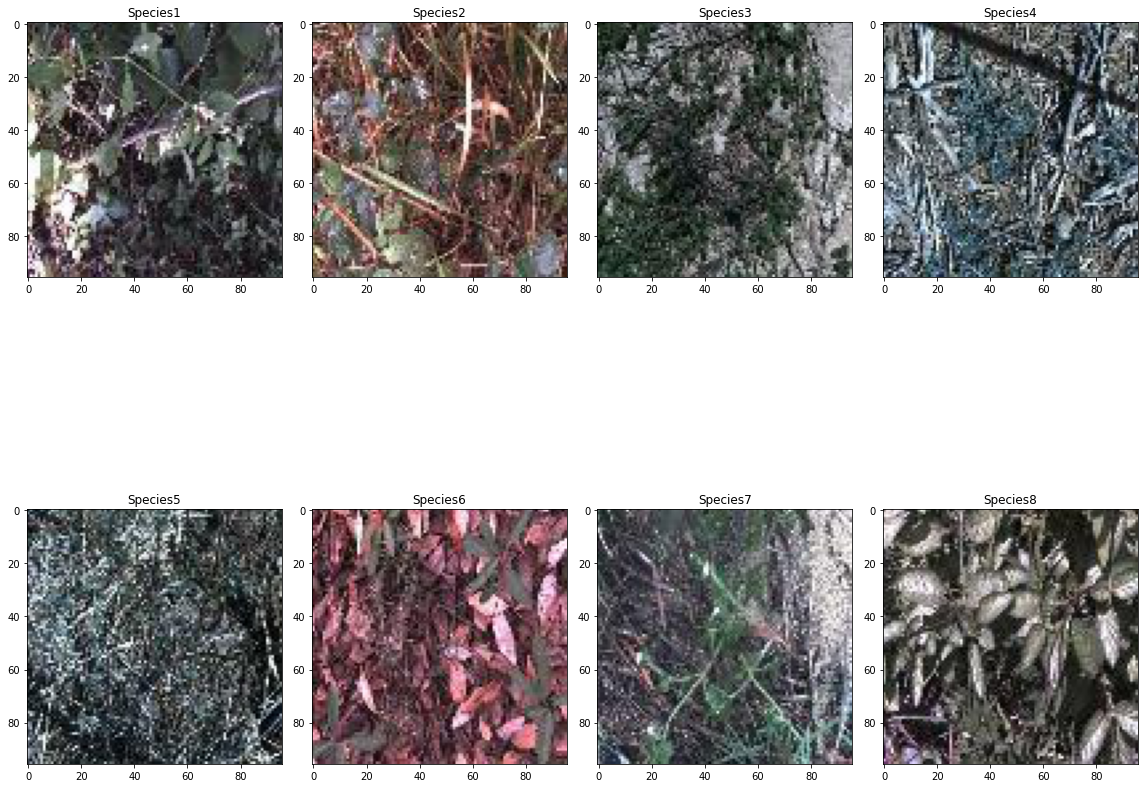

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/val/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/val/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#DIRECTORY OF BOTH TRAINING AND VALIDATION SET
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

parmeters that have to be changed everytime according to model structure

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#DATA AUGMENTATION: ROTATION,SHIFT,ZOOM,BRIGHTNESS,FLIPS,PREPROCESSING TYPICAL OF RESNET

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=35,
                                        height_shift_range=0.33,
                                        width_shift_range=0.33,
                                        zoom_range=0.25,
                                        brightness_range = (0.8,1.2),
                                        shear_range = 0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input
                                        ) # rescale value is multiplied to the image

valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (224,224),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
#METADETA
input_shape = (224, 224, 3)
epochs = 100

### CNN MODEL

In [ ]:
#DOWNLOAD THE RESNET50V2: USE WEIGHTS OF IMAGENET ALSO SET ALL THE LAYERS TO FALSE
resnet50 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in resnet50.layers:
  layer.trainable = False
resnet50.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
#MODEL: INPUT + RESIZING + RESNET50V2 + THREE DENSE LAYERS(WITH RIDGE REGRESSION)
inputs = tfk.Input(shape=(96,96,3))

x= tfkl.Resizing(224,224,interpolation="nearest", crop_to_aspect_ratio=False)(inputs)

x = resnet50(x)
x = tfkl.Flatten(name='Flattening')(x)

x = tfkl.Dense(
    64, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )(x)

x= tfkl.Dropout(0.15, seed=seed)(x)

x = tfkl.Dense(
    32, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )(x)

x= tfkl.Dropout(0.15, seed=seed)(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)


resnet50 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
resnet50.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 Flattening (Flatten)        (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080  

In [ ]:
#TO OVERCOME THE PROBLEMS DUE TO SLIGHTLY IMBALANCED DATASET
class_weights = {0: 1. ,1: 2.86 ,2: 2.77 ,3: 2.75 ,4: 2.85 ,5: 1.19 ,6: 2.89 ,7: 2.73 }

In [ ]:
# Train the model: FOR 100 EPOCHS AND WITH EARLY STOPPING
history = resnet50.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/100
89/89 [==============================] - 26s 169ms/step - loss: 6.4162 - accuracy: 0.2340 - val_loss: 1.8040 - val_accuracy: 0.3212
Epoch 2/100
89/89 [==============================] - 16s 179ms/step - loss: 4.7815 - accuracy: 0.2881 - val_loss: 1.6632 - val_accuracy: 0.3857
Epoch 3/100
89/89 [==============================] - 16s 177ms/step - loss: 4.5099 - accuracy: 0.2959 - val_loss: 1.6423 - val_accuracy: 0.3492
Epoch 4/100
89/89 [==============================] - 14s 152ms/step - loss: 4.3802 - accuracy: 0.3100 - val_loss: 1.6174 - val_accuracy: 0.3689
Epoch 5/100
89/89 [==============================] - 13s 149ms/step - loss: 4.4832 - accuracy: 0.3089 - val_loss: 1.6840 - val_accuracy: 0.3871
Epoch 6/100
89/89 [==============================] - 13s 151ms/step - loss: 4.2551 - accuracy: 0.3443 - val_loss: 1.6295 - val_accuracy: 0.4418
Epoch 7/100
89/89 [==============================] - 14s 157ms/step - loss: 4.1705 - accuracy: 0.3726 - val_loss: 1.6351 - val_accuracy:

### Plot the training

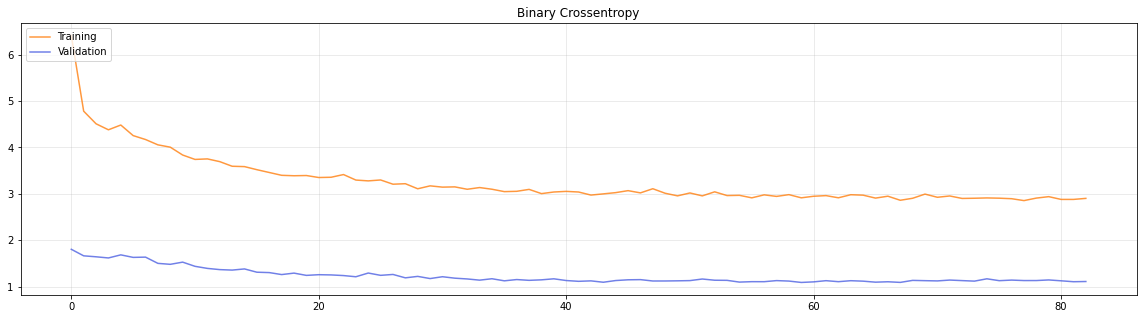

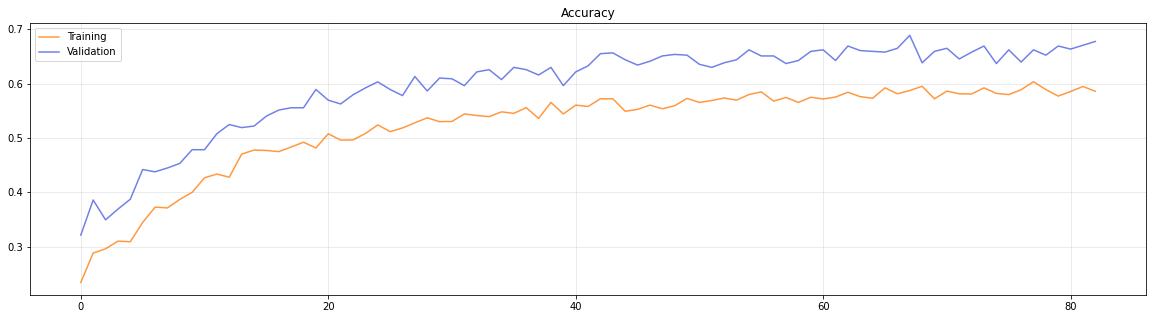

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resnet50.save('/content/drive/MyDrive/Final/resnet50_tl')

In [ ]:
%cd /content/drive/MyDrive/Final

/content/drive/MyDrive/Final


### Fine Tuning

In [ ]:
ft_model = tfk.models.load_model('resnet50_tl')

In [ ]:
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 Flattening (Flatten)        (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080  

In [ ]:
# Set all resnet layers to True
ft_model.get_layer('resnet50v2').trainable = True
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d True

In [ ]:
#UNFREEZE LAYERS
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:150]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/100
89/89 [==============================] - 21s 185ms/step - loss: 3.5148 - accuracy: 0.4981 - val_loss: 1.1657 - val_accuracy: 0.6269
Epoch 2/100
89/89 [==============================] - 15s 164ms/step - loss: 3.1237 - accuracy: 0.5511 - val_loss: 1.2452 - val_accuracy: 0.6003
Epoch 3/100
89/89 [==============================] - 14s 161ms/step - loss: 2.9440 - accuracy: 0.5797 - val_loss: 1.0308 - val_accuracy: 0.6985
Epoch 4/100
89/89 [==============================] - 14s 161ms/step - loss: 2.7444 - accuracy: 0.6041 - val_loss: 1.0274 - val_accuracy: 0.7013
Epoch 5/100
89/89 [==============================] - 14s 162ms/step - loss: 2.6752 - accuracy: 0.6136 - val_loss: 1.0345 - val_accuracy: 0.6928
Epoch 6/100
89/89 [==============================] - 15s 165ms/step - loss: 2.5834 - accuracy: 0.6317 - val_loss: 0.9808 - val_accuracy: 0.7251
Epoch 7/100
89/89 [==============================] - 14s 159ms/step - loss: 2.5591 - accuracy: 0.6462 - val_loss: 0.9378 - val_accuracy:

In [ ]:
ft_model.save('/content/drive/MyDrive/Final/resnet50v2_ft')

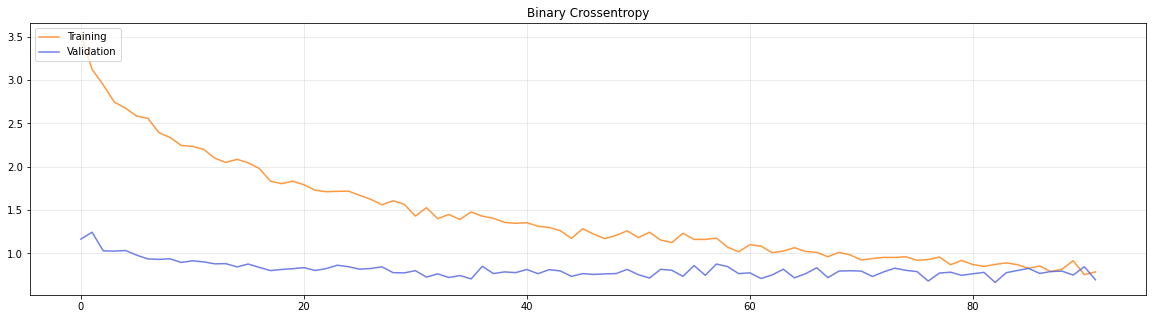

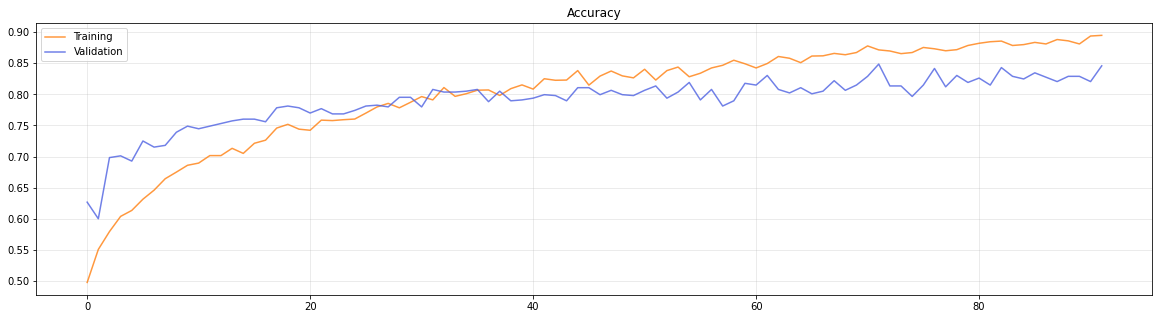

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()